In [1]:
from PyRDF import *

Welcome to JupyROOT 6.15/01


In [2]:
use("local")

In [3]:
tdf = RDataFrame("data", ['CMS_Open_Dataset.root'])

In [4]:
chargeCutStr = "C1 != C2"
etaCutStr = "fabs(eta1) < 2.3 && fabs(eta2) < 2.3"
ptCutStr = "pt1 > 2 && pt2 > 2"
tdf_f = tdf.Filter(chargeCutStr, "Opposite Charge") \
           .Filter(etaCutStr, "Central Muons") \
           .Filter(ptCutStr, "Sane Pt")

In [5]:
# Create the invariant mass column
invMassFormulaStr = "sqrt(pow(E1+E2, 2) - (pow(px1+px2, 2) + pow(py1+py2, 2) + pow(pz1+pz2, 2)))"
tdf_fd = tdf_f.Define("invMass", invMassFormulaStr)#.Filter('cout<<" Event loop running !\\n";')

# Create the histograms
pt1_h = tdf.Histo1D(("","",128,1,1200), "pt1")
pt2_h = tdf.Histo1D(("","",128,1,1200), "pt2")
invMass_h = tdf_fd.Histo1D(("invMass","CMS Opendata;#mu#mu mass [GeV];Events",512,5,110), "invMass")
import ROOT
pi = ROOT.TMath.Pi()
phis_h = tdf_fd.Histo2D(("", "", 64, -pi, pi, 64, -pi, pi), "phi1", "phi2")


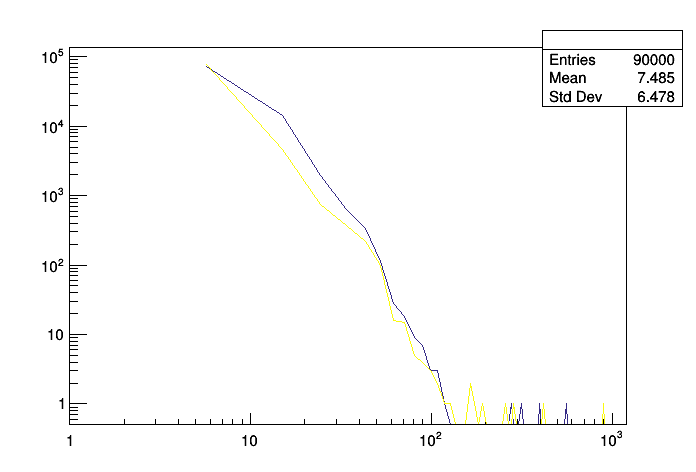

In [6]:
muonsPts = ROOT.TCanvas()
pt1_h.Draw("PL PLC PMC")
pt2_h.Draw("Same PL PLC PMC")
muonsPts.SetLogy()
muonsPts.SetLogx()
muonsPts.Draw()

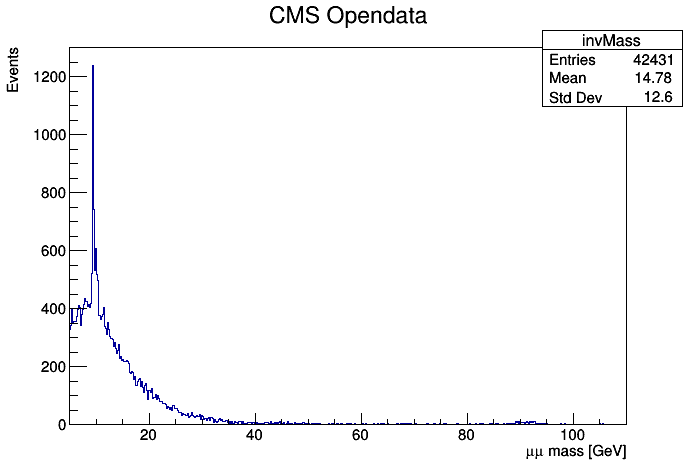

In [7]:
phis = ROOT.TCanvas()
invMass_h.Draw("col")
phis.Draw()

In [8]:
tf_count_i = tdf.Count()
tf_count = tdf_f.Count()
print(tf_count.GetValue())
print(tf_count_i.GetValue())

42431
90000


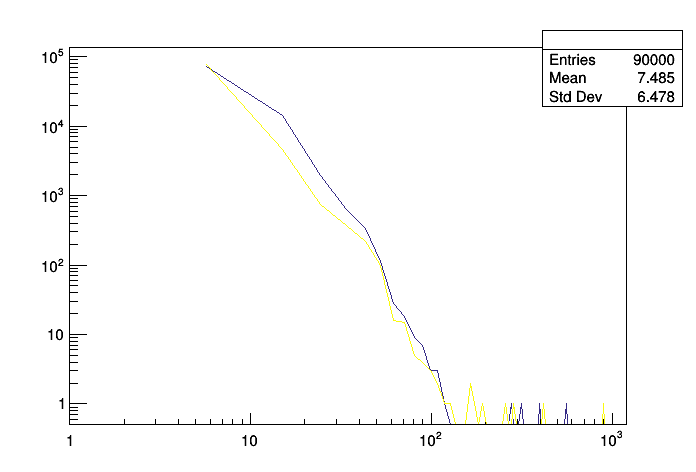

In [9]:
muonsPts = ROOT.TCanvas()
pt1_h.Draw("PL PLC PMC")
pt2_h.Draw("Same PL PLC PMC")
muonsPts.SetLogy()
muonsPts.SetLogx()
muonsPts.Draw()

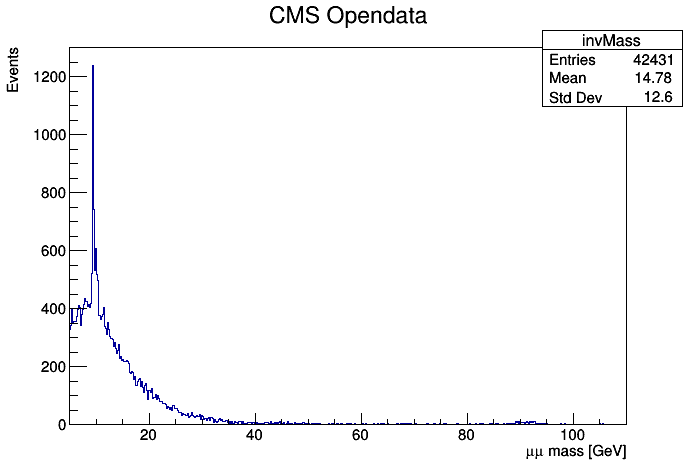

In [10]:
phis = ROOT.TCanvas()
invMass_h.Draw("col")
phis.Draw()